In [184]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [185]:
# 加载数据
data = pd.read_excel('./data/cleaned_data.xlsx', sheet_name='Sheet1')

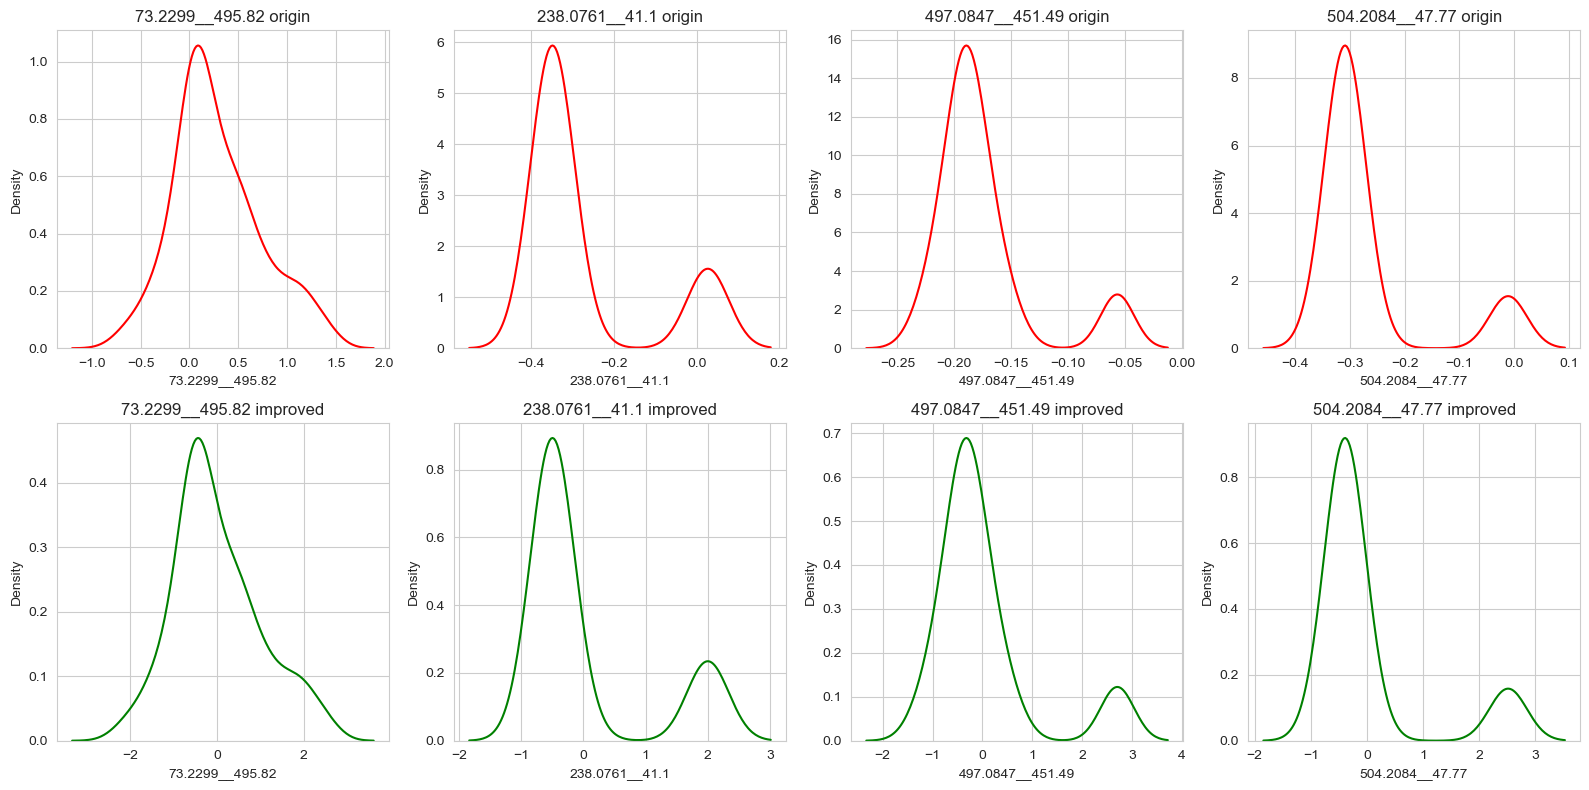

In [186]:
# 分离特征和标签
X = data.drop(columns=["label"])
Y = data["label"]

# 编码标签
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Y)

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 将缩放前和缩放后的数据都转为 DataFrame 便于绘图
X_df = pd.DataFrame(X, columns=X.columns)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# 以某些代表性特征来可视化对比
features_to_plot = X.columns[1:5]

plt.figure(figsize=(16, 8))
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 4, i+1)
    sns.kdeplot(X_df[feature], label="原始", color='red')
    plt.title(f"{feature} origin")
    
    plt.subplot(2, 4, i+5)
    sns.kdeplot(X_scaled_df[feature], label="归一化", color='green')
    plt.title(f"{feature} improved")

plt.tight_layout()
plt.show()

In [187]:
# 特征选择（基于 XGBoost 特征重要性）
xgb_selector = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    max_depth=6,
    learning_rate=0.1,
    n_estimators=800
)
selector = SelectFromModel(xgb_selector, threshold='median')
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]

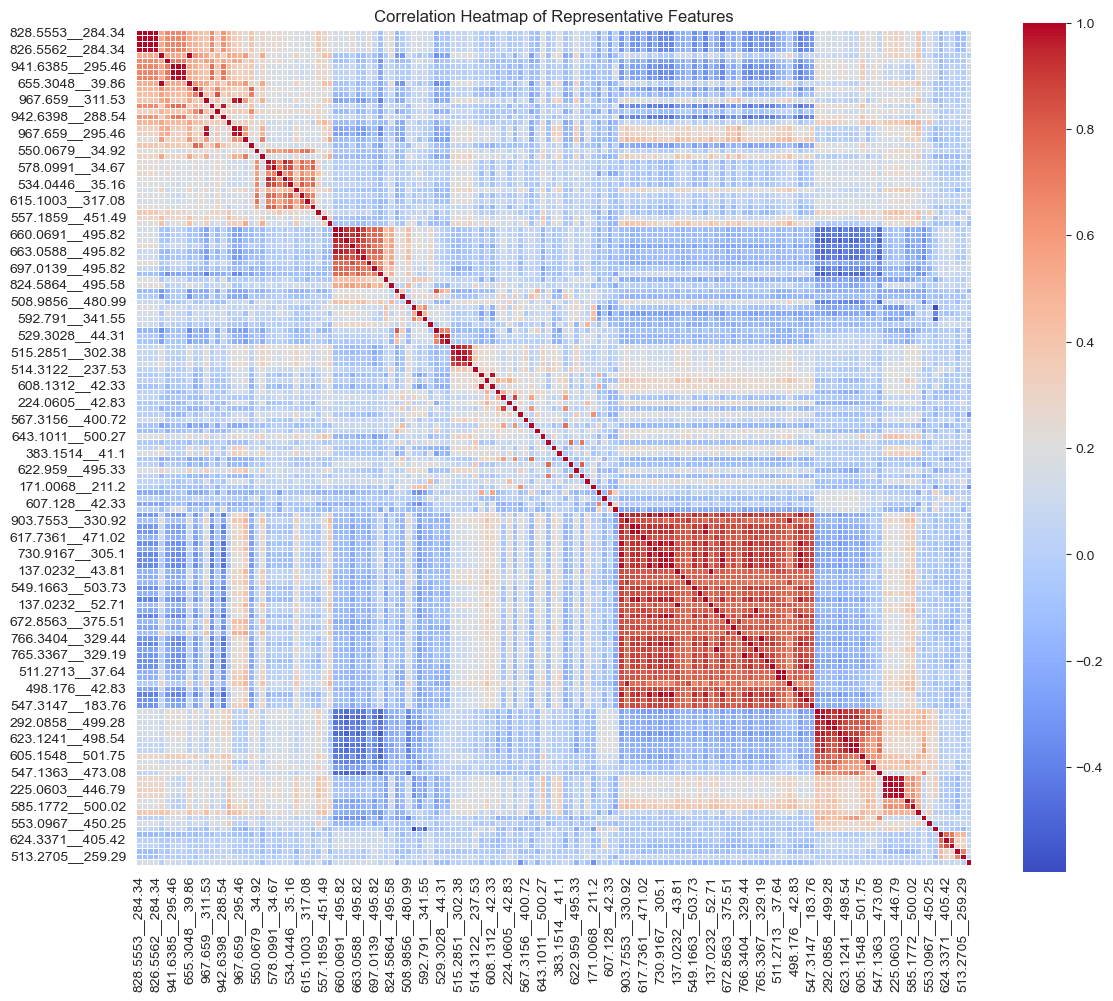

In [188]:
# -------- 特征聚类（直接在原始数据上聚类） --------
def cluster_features(X, feature_names, max_clusters=10):
    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(X.T)  # 转置X以按特征聚类
        score = silhouette_score(X.T, labels)  # silhouette_score
        silhouette_scores.append(score)

    optimal_clusters = np.argmax(silhouette_scores) + 2
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X.T)

    clusters = {}
    for idx, label in enumerate(cluster_labels):
        clusters.setdefault(label, []).append(feature_names[idx])

    return clusters, kmeans.cluster_centers_

# -------- 聚类 + 选择代表特征 --------
clusters, cluster_centers = cluster_features(X_scaled, selected_features)

# 选择每个聚类中最能代表该聚类的特征
representative_features = []
for cluster_idx, features in clusters.items():
    center = cluster_centers[cluster_idx]
    # 计算每个特征与聚类中心的距离
    feature_distances = np.linalg.norm(X_scaled[:, [selected_features.to_list().index(f) for f in features]].T - center, axis=1)
    
    # 按照距离排序，选择最具代表性的特征
    sorted_features = [features[i] for i in np.argsort(feature_distances)]
    representative_features.extend(sorted_features[:35])  # 每个聚类最多保留5个特征

X_reduced = pd.DataFrame(X_scaled, columns=X.columns)[representative_features]

# -------- 1. 相关系数热力图 --------
plt.figure(figsize=(12, 10))
sns.heatmap(X_reduced.corr(), cmap="coolwarm", annot=False, square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Representative Features")
plt.tight_layout()
plt.show()


In [189]:
# 移除可能存在标签错误的样本
def remove_ambiguous_samples(X, y, threshold=0.5):
    model = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        max_depth=5,
        learning_rate=0.05,
        n_estimators=1000,
        min_child_weight=3,
        subsample=0.7,
        colsample_bytree=0.7,
        gamma=0.2,
        alpha=0.1,
        reg_lambda=2
    )
    model.fit(X, y)
    proba = model.predict_proba(X)
    max_proba = np.max(proba, axis=1)
    mask = max_proba >= threshold
    return X[mask], y[mask]

X_clean, y_clean = remove_ambiguous_samples(X_reduced, y)

In [190]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, stratify=y_clean, random_state=42)

# 处理类别不平衡
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [191]:
# 定义基模型
base_learners = [
    ('xgb', XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        max_depth=5,
        learning_rate=0.05,
        n_estimators=1000,
        min_child_weight=3,
        subsample=0.7,
        colsample_bytree=0.7,
        gamma=0.2,
        alpha=0.1,
        reg_lambda=2
    )),
    ('rf', RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        min_samples_split=5,
        min_samples_leaf=3,
        max_features='log2',
        class_weight='balanced',
        random_state=42
    ))
]

# 定义元学习器
meta_learner = LogisticRegression()

# 构建堆叠模型
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

# 交叉验证
scores = cross_val_score(stacking_model, X_train_resampled, y_train_resampled, cv=5, scoring='accuracy')
print(f"交叉验证准确率: {scores.mean():.4f} ± {scores.std():.4f}")


交叉验证准确率: 0.9031 ± 0.0462


In [192]:
# 训练模型
stacking_model.fit(X_train_resampled, y_train_resampled)

# 预测并评估
y_train_pred = stacking_model.predict(X_train_resampled)
y_test_pred = stacking_model.predict(X_test)

train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"训练集准确率: {train_accuracy:.4f}")
print(f"测试集准确率: {test_accuracy:.4f}")

训练集准确率: 1.0000
测试集准确率: 0.8298
